HDVAE(
  (encoder_x_to_z1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc_mu1): Linear(in_features=128, out_features=64, bias=True)
  (fc_logvar1): Linear(in_features=128, out_features=64, bias=True)
  (encoder_z1_to_z2): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc_mu2): Linear(in_features=64, out_features=32, bias=True)
  (fc_logvar2): Linear(in_features=64, out_features=32, bias=True)
  (encoder_z2_to_z3): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc_mu3): Linear(in_features=64, out_feature

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


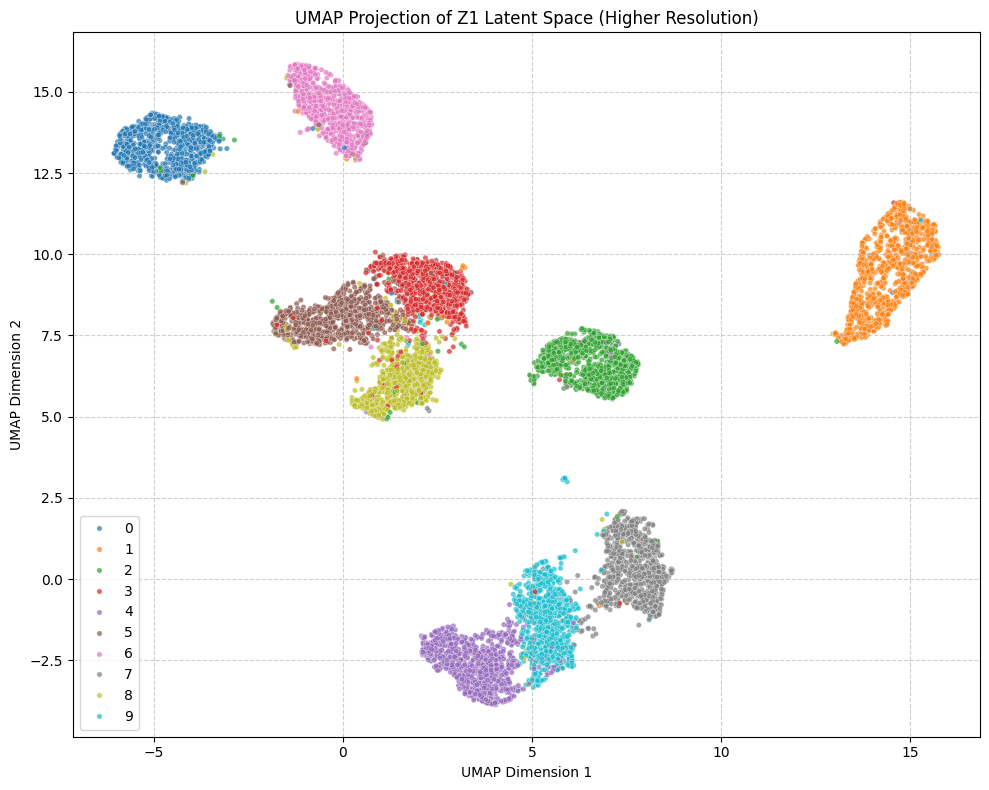

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


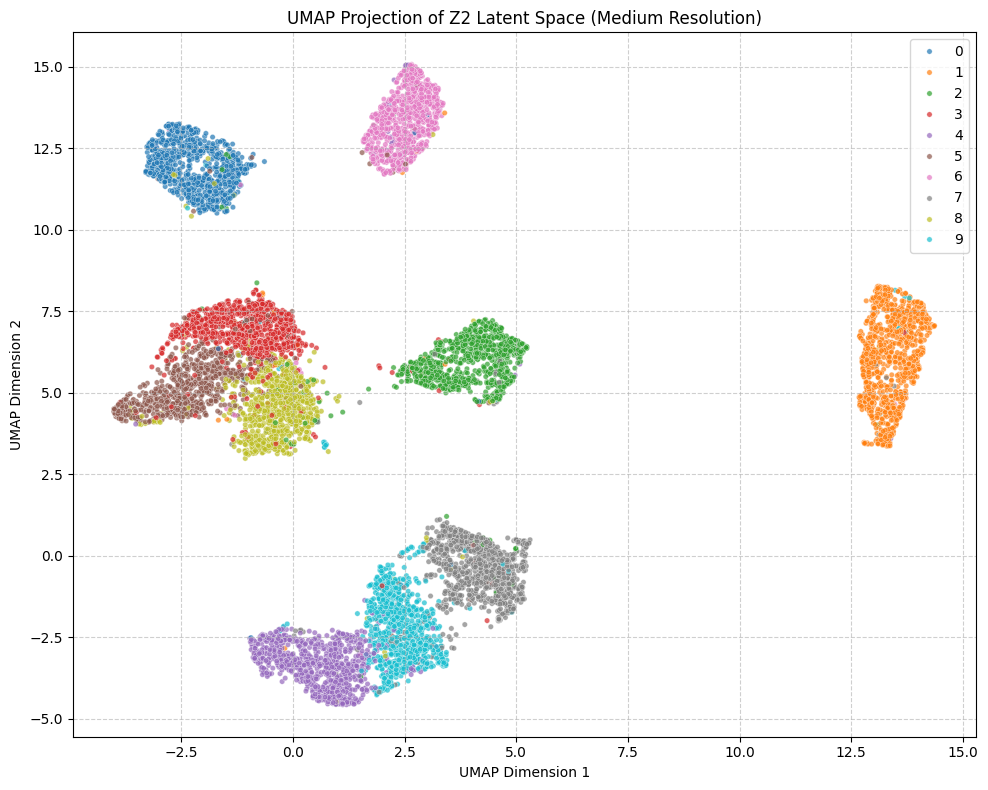

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


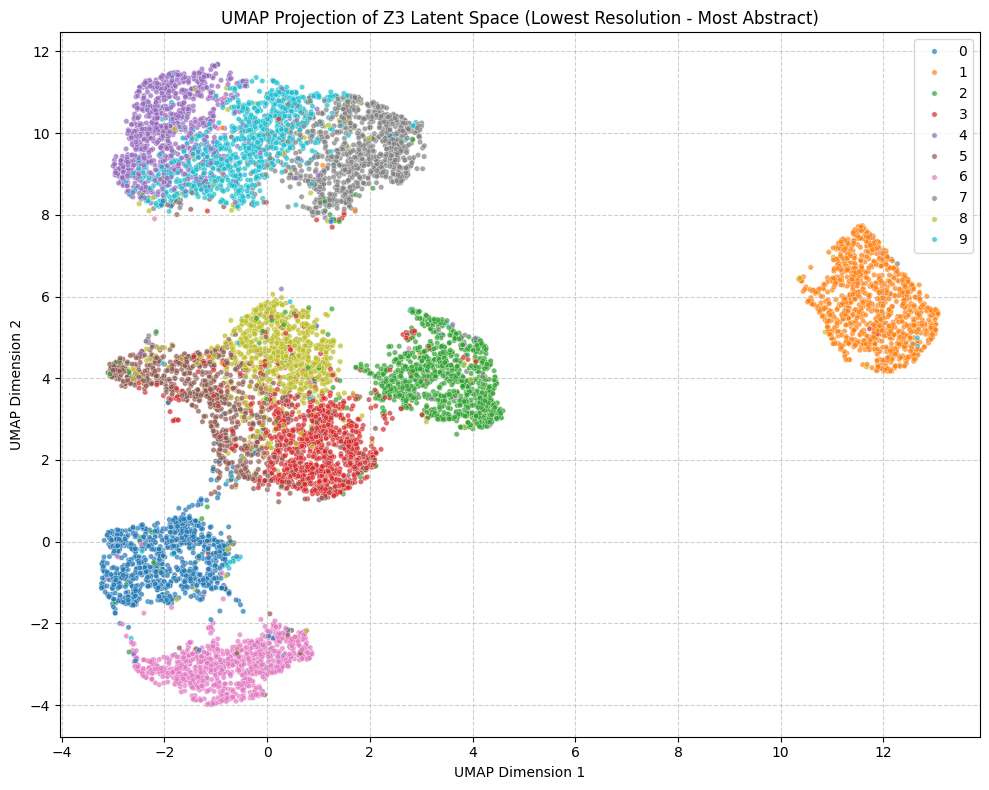

Latent space plots (by digit label) generated in './latent_space_plots/' directory.


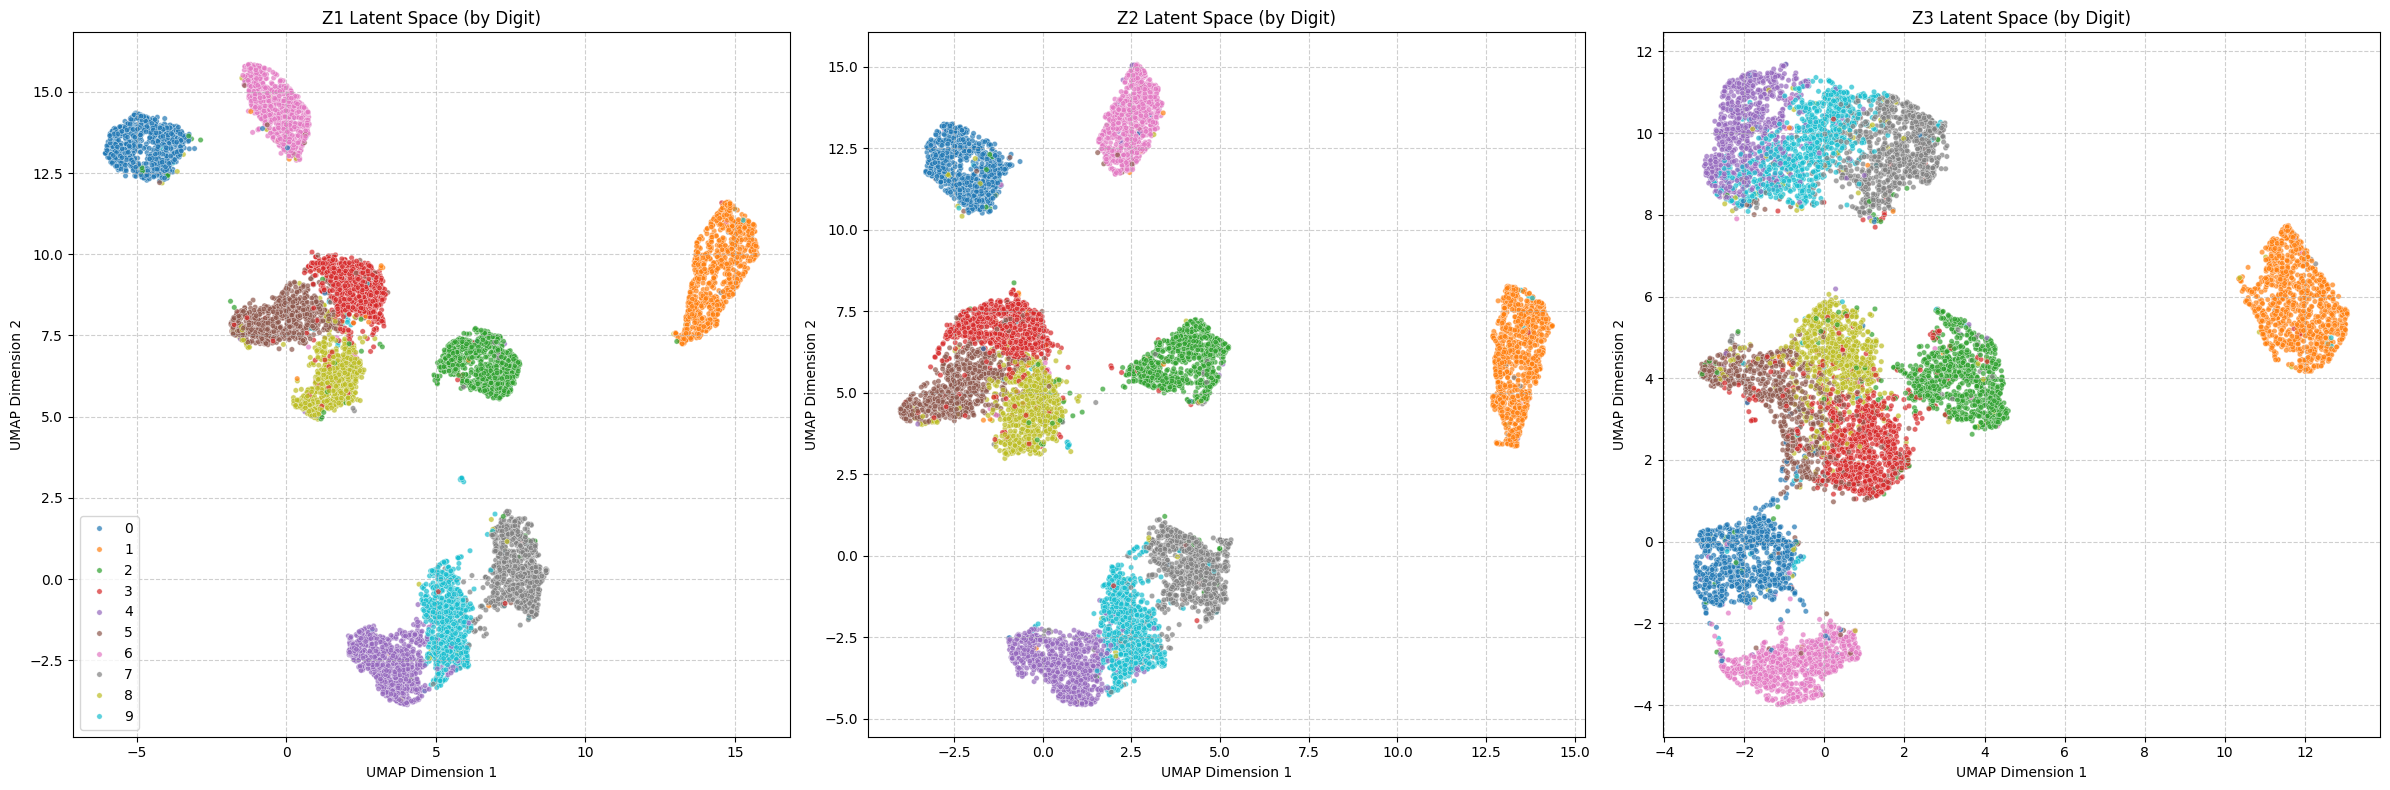


Preparing data for inter-layer UMAP plot...
Applying UMAP to combined latent spaces for inter-layer comparison (N=30000, D=64)...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


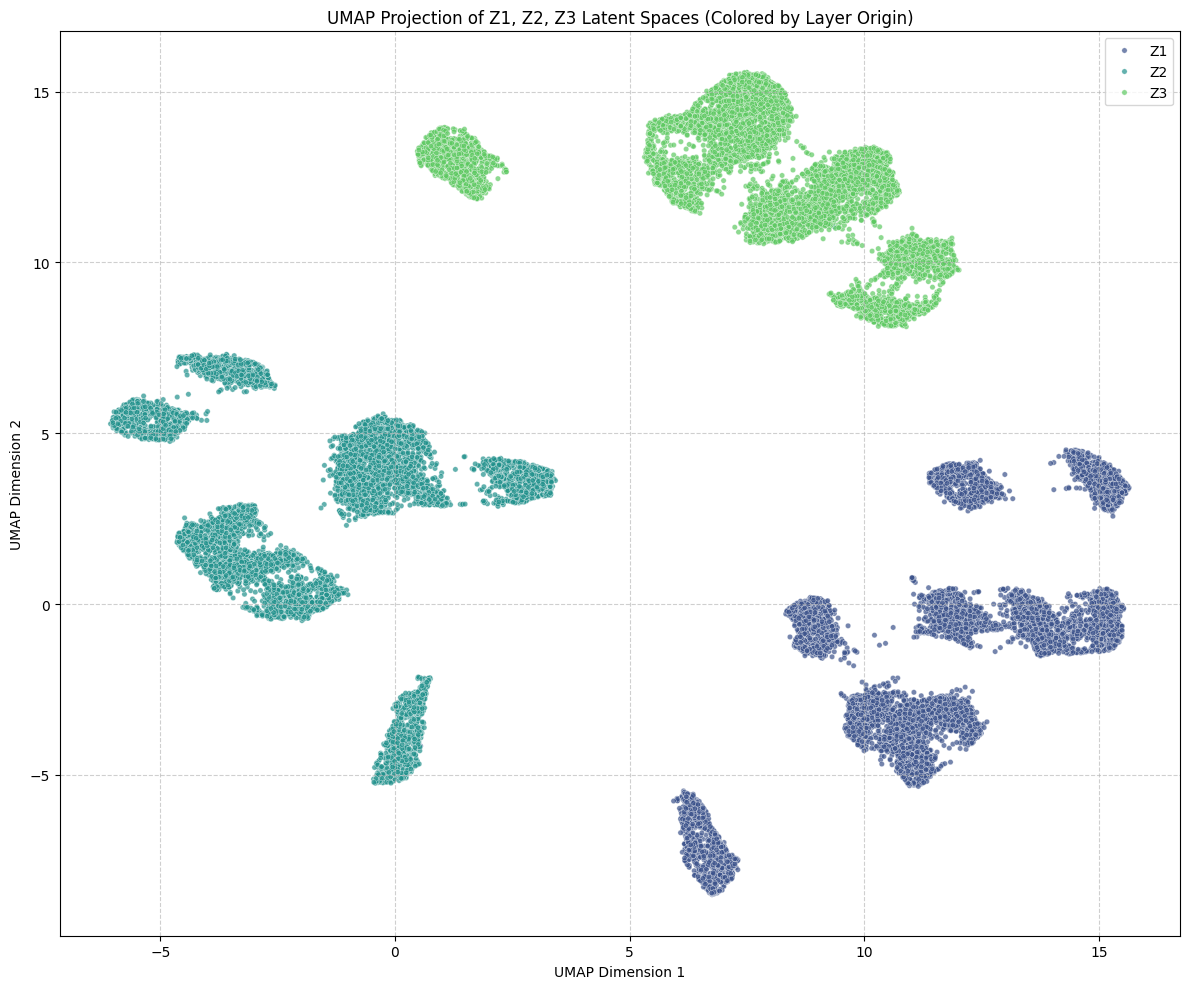

Inter-layer UMAP plot generated: ./latent_space_plots/umap_all_layers_combined.png


In [6]:
# V4: 3-layer Hierarchy + UMAP + z1z2z3 UMAP + Beta for KLD terms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np
import matplotlib.pyplot as plt
import umap # For UMAP visualization
from sklearn.manifold import TSNE # For t-SNE visualization (optional)
import seaborn as sns # For better looking plots

# (Your existing imports and Hyper-parameters)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
image_size = 784
z1_dim = 64
z2_dim = 32
z3_dim = 16
num_epochs = 40 # Increased epochs for better latent space learning
batch_size = 128
learning_rate = 1e-3

# Create directories (ensure ./latent_space_plots exists)
os.makedirs('./sampled_images_hdvae', exist_ok=True)
os.makedirs('./plots_hdvae', exist_ok=True)
os.makedirs('./latent_space_plots', exist_ok=True) # New directory for latent space plots

# (Your existing dataset loading and HDVAE class definition)
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) # Use batch_size for collecting latents

test_loader_fixed_batch = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)
fixed_test_images, _ = next(iter(test_loader_fixed_batch))
fixed_test_images = fixed_test_images.to(device)


# HDVAE Model - 3 Hierarchical Latent Layers (z1, z2, z3) - Same as before
class HDVAE(nn.Module):
    def __init__(self, image_size, z1_dim, z2_dim, z3_dim):
        super(HDVAE, self).__init__()
        self.image_size = image_size
        self.z1_dim = z1_dim
        self.z2_dim = z2_dim
        self.z3_dim = z3_dim

        # Encoder X -> Z1 (Kept current deeper structure)
        self.encoder_x_to_z1 = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.fc_mu1 = nn.Linear(128, z1_dim)
        self.fc_logvar1 = nn.Linear(128, z1_dim)

        # Encoder Z1 -> Z2 (Kept current deeper structure)
        self.encoder_z1_to_z2 = nn.Sequential(
            nn.Linear(z1_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.fc_mu2 = nn.Linear(64, z2_dim)
        self.fc_logvar2 = nn.Linear(64, z2_dim)

        # NEW: Encoder Z2 -> Z3
        self.encoder_z2_to_z3 = nn.Sequential(
            nn.Linear(z2_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.fc_mu3 = nn.Linear(64, z3_dim)
        self.fc_logvar3 = nn.Linear(64, z3_dim)

        # NEW: Decoder Z3 -> Z2 (Prior for Z2)
        self.decoder_z3_to_z2_params = nn.Sequential(
            nn.Linear(z3_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        self.fc_prior_mu2 = nn.Linear(128, z2_dim)
        self.fc_prior_logvar2 = nn.Linear(128, z2_dim)

        # Decoder Z2 -> Z1 (Prior for Z1 - Kept current deeper structure)
        self.decoder_z2_to_z1_params = nn.Sequential(
            nn.Linear(z2_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        self.fc_prior_mu1 = nn.Linear(128, z1_dim)
        self.fc_prior_logvar1 = nn.Linear(128, z1_dim)

        # Decoder Z1 -> X (Kept current deeper structure)
        self.decoder_z1_to_x = nn.Sequential(
            nn.Linear(z1_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        h1 = self.encoder_x_to_z1(x.view(-1, self.image_size))
        mu1, log_var1 = self.fc_mu1(h1), self.fc_logvar1(h1)
        z1 = self.reparameterize(mu1, log_var1)

        h2 = self.encoder_z1_to_z2(z1)
        mu2, log_var2 = self.fc_mu2(h2), self.fc_logvar2(h2)
        z2 = self.reparameterize(mu2, log_var2)

        h3 = self.encoder_z2_to_z3(z2)
        mu3, log_var3 = self.fc_mu3(h3), self.fc_logvar3(h3)
        z3 = self.reparameterize(mu3, log_var3)

        return (mu1, log_var1, z1), (mu2, log_var2, z2), (mu3, log_var3, z3)

    def decode(self, z1, z2, z3):
        x_reconst = self.decoder_z1_to_x(z1)

        h_prior_z1 = self.decoder_z2_to_z1_params(z2)
        mu_prior_1 = self.fc_prior_mu1(h_prior_z1)
        log_var_prior_1 = self.fc_prior_logvar1(h_prior_z1)

        h_prior_z2 = self.decoder_z3_to_z2_params(z3)
        mu_prior_2 = self.fc_prior_mu2(h_prior_z2)
        log_var_prior_2 = self.fc_prior_logvar2(h_prior_z2)

        return x_reconst, (mu_prior_1, log_var_prior_1), (mu_prior_2, log_var_prior_2)

    def forward(self, x):
        (mu1, log_var1, z1), (mu2, log_var2, z2), (mu3, log_var3, z3) = self.encode(x)
        x_reconst, (mu_prior_1, log_var_prior_1), (mu_prior_2, log_var_prior_2) = self.decode(z1, z2, z3)

        return x_reconst, mu1, log_var1, z1, mu2, log_var2, z2, mu3, log_var3, z3, \
               mu_prior_1, log_var_prior_1, mu_prior_2, log_var_prior_2

# Instantiate the model
model = HDVAE(image_size, z1_dim, z2_dim, z3_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

# Loss Function - Same as before
def loss_function_hdvae(recon_x, x, mu1, log_var1, mu2, log_var2, mu3, log_var3, mu_prior_1, log_var_prior_1, mu_prior_2, log_var_prior_2,
                        beta1=1.0, beta2=1.0, beta3=1.0): # Add beta parameters
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, image_size), reduction='sum')

    # Assuming Z3 is the top-most layer, so its prior is N(0,I)
    KLD_z3 = -0.5 * torch.sum(1 + log_var3 - mu3.pow(2) - log_var3.exp())

    KLD_z2 = 0.5 * torch.sum(
        torch.exp(log_var2 - log_var_prior_2) +
        ((mu_prior_2 - mu2)**2) * torch.exp(-log_var_prior_2) - 1 +
        (log_var_prior_2 - log_var2)
    )

    KLD_z1 = 0.5 * torch.sum(
        torch.exp(log_var1 - log_var_prior_1) +
        ((mu_prior_1 - mu1)**2) * torch.exp(-log_var_prior_1) - 1 +
        (log_var_prior_1 - log_var1)
    )

    # Apply beta factors
    return BCE + beta1 * KLD_z1 + beta2 * KLD_z2 + beta3 * KLD_z3

def calculate_metrics(original_images, reconstructed_images):
    original_np = original_images.detach().cpu().numpy().reshape(-1, 28, 28)
    reconstructed_np = reconstructed_images.detach().cpu().numpy().reshape(-1, 28, 28)
    psnr_scores = []
    ssim_scores = []
    for i in range(original_np.shape[0]):
        img_o = original_np[i]
        img_r = reconstructed_np[i]
        psnr = peak_signal_noise_ratio(img_o, img_r, data_range=1)
        psnr_scores.append(psnr)
        ssim = structural_similarity(img_o, img_r, data_range=1)
        ssim_scores.append(ssim)
    return np.mean(psnr_scores), np.mean(ssim_scores)

def plot_originals_and_reconstructions(original_images, reconstructed_images, title="", num_display=8):
    original_images = original_images.detach().cpu().squeeze()
    reconstructed_images = reconstructed_images.detach().cpu().squeeze()

    original_display = original_images[:num_display]
    reconstructed_display = reconstructed_images[:num_display]

    fig, axes = plt.subplots(2, num_display, figsize=(num_display * 1.5, 3))

    for i in range(num_display):
        axes[0, i].imshow(original_display[i].numpy(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_title("Original", fontsize=8)

    for i in range(num_display):
        axes[1, i].imshow(reconstructed_display[i].numpy(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0: axes[1, i].set_title("Reconstructed", fontsize=8)

    plt.suptitle(title, y=1.05, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 1.0])
    plt.show()
    plt.close(fig)

def plot_sampled_images(sampled_images, title="", num_display=8, filename=None):
    sampled_images = sampled_images.detach().cpu().squeeze()

    fig, axes = plt.subplots(1, num_display, figsize=(num_display * 1.5, 1.5))

    for i in range(num_display):
        axes[i].imshow(sampled_images[i].numpy(), cmap='gray')
        axes[i].axis('off')

    plt.suptitle(title, y=1.05, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 1.0])
    if filename:
        plt.savefig(filename)
    plt.show()
    plt.close(fig)

def plot_latent_space(latent_coords, labels, title, filename):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=latent_coords[:, 0], y=latent_coords[:, 1],
        hue=labels,
        palette=sns.color_palette("tab10", 10),
        legend="full",
        alpha=0.7,
        s=15 # Adjust point size
    )
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()

def plot_all_latent_spaces_together(embeddings, labels, titles): # Removed filename, can save separately
    num_plots = len(embeddings)
    fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 8, 8))

    # Ensure axes is an array even for single plot case
    if num_plots == 1:
        axes = [axes]

    for i in range(num_plots):
        sns.scatterplot(
            x=embeddings[i][:, 0], y=embeddings[i][:, 1],
            hue=labels,
            palette=sns.color_palette("tab10", 10),
            legend="full" if i == 0 else False, # Only show legend once
            alpha=0.7,
            s=15,
            ax=axes[i] # Plot on specific subplot
        )
        axes[i].set_title(titles[i])
        axes[i].set_xlabel("UMAP Dimension 1")
        axes[i].set_ylabel("UMAP Dimension 2")
        axes[i].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig(os.path.join("./latent_space_plots/", "all_umap_plots_combined_by_digit.png")) # Save for clarity
    plt.show()
    plt.close()


# --- NEW FUNCTION: Plotting Z1, Z2, Z3 on one UMAP ---
def plot_inter_layer_umap(all_latent_data, layer_labels, filename):
    """
    Plots the UMAP projection of concatenated Z1, Z2, Z3 means,
    colored by their originating layer (Z1, Z2, Z3).

    Args:
        all_latent_data (np.array): Concatenated mu1, mu2, mu3 data.
        layer_labels (np.array): Labels indicating origin layer ('Z1', 'Z2', 'Z3').
        filename (str): Path to save the plot.
    """
    print(f"Applying UMAP to combined latent spaces for inter-layer comparison (N={all_latent_data.shape[0]}, D={all_latent_data.shape[1]})...")

    # Initialize UMAP reducer. Adjust n_neighbors and min_dist if needed for different structures.
    # n_neighbors=15 (default) works well for balanced local/global structure.
    # For denser, more separated clusters, try lower min_dist (e.g., 0.1).
    reducer_combined = umap.UMAP(random_state=42)
    embedding_combined = reducer_combined.fit_transform(all_latent_data)

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x=embedding_combined[:, 0], y=embedding_combined[:, 1],
        hue=layer_labels,
        palette="viridis", # Or "deep", "Paired", etc. for distinct colors
        legend="full",
        alpha=0.7,
        s=15
    )
    plt.title("UMAP Projection of Z1, Z2, Z3 Latent Spaces (Colored by Layer Origin)")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()
    print(f"Inter-layer UMAP plot generated: {filename}")


# --- Training Loop (as before) ---
# --- Variables to store reconstruction and sampled data for the last epoch ---
last_epoch_original_images = None
last_epoch_reconstructed_images = None
last_epoch_sampled_images = None


# Training loop
print("Starting HDVAE training with 3 hierarchical layers...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        recon_images, mu1, log_var1, z1, mu2, log_var2, z2, mu3, log_var3, z3, \
               mu_prior_1, log_var_prior_1, mu_prior_2, log_var_prior_2 = model(images)


        ### MRH:
        ################ linear annealing for Beta  in loss function:
        num_annealing_epochs = num_epochs / 2
        beta_annealing_factor = min(1.0, epoch / num_annealing_epochs) # e.g., num_annealing_epochs = num_epochs / 2
        max_beta1 = 0.5
        max_beta2 = 0.2
        max_beta3 = 0.1
        current_beta1 = beta_annealing_factor * max_beta1
        current_beta2 = beta_annealing_factor * max_beta2
        current_beta3 = beta_annealing_factor * max_beta3
        ################

        loss = loss_function_hdvae(recon_images, images,
                                   mu1, log_var1,
                                   mu2, log_var2,
                                   mu3, log_var3,
                                   mu_prior_1, log_var_prior_1,
                                   mu_prior_2, log_var_prior_2, beta1=current_beta1, beta2=current_beta2, beta3=current_beta3)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader.dataset)

    # --- Evaluation ---
    model.eval()
    with torch.no_grad():
        recon_images_fixed_current_epoch, _, _, _, _, _, _, _, _, _, _, _, _, _ = model(fixed_test_images)

        last_epoch_original_images = fixed_test_images.clone().detach()
        last_epoch_reconstructed_images = recon_images_fixed_current_epoch.view(-1, 1, 28, 28).clone().detach()

        z3_sample = torch.randn(8, z3_dim).to(device)
        h_prior_z2_sample = model.decoder_z3_to_z2_params(z3_sample)
        mu_prior_2_sample = model.fc_prior_mu2(h_prior_z2_sample)
        log_var_prior_2_sample = model.fc_prior_logvar2(h_prior_z2_sample)
        z2_sample = model.reparameterize(mu_prior_2_sample, log_var_prior_2_sample)

        h_prior_z1_sample = model.decoder_z2_to_z1_params(z2_sample)
        mu_prior_1_sample = model.fc_prior_mu1(h_prior_z1_sample)
        log_var_prior_1_sample = model.fc_prior_logvar1(h_prior_z1_sample)
        z1_sample = model.reparameterize(mu_prior_1_sample, log_var_prior_1_sample)

        sampled_out = model.decoder_z1_to_x(z1_sample).view(-1, 1, 28, 28)
        last_epoch_sampled_images = sampled_out.clone().detach()

        psnr, ssim = calculate_metrics(fixed_test_images, recon_images_fixed_current_epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Avg Loss: {avg_loss:.4f}, PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")

print("Training complete!")


# --- Post-training Latent Space Visualization (Existing Code) ---
print("\nCollecting latent space means for visualization (by digit label)...")
all_mu1s = []
all_mu2s = []
all_mu3s = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        (mu1, _, _), (mu2, _, _), (mu3, _, _) = model.encode(images)

        all_mu1s.append(mu1.cpu().numpy())
        all_mu2s.append(mu2.cpu().numpy())
        all_mu3s.append(mu3.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_mu1s = np.concatenate(all_mu1s, axis=0)
all_mu2s = np.concatenate(all_mu2s, axis=0)
all_mu3s = np.concatenate(all_mu3s, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("Applying UMAP to latent space means (by digit label)...")

reducer_z1 = umap.UMAP(random_state=42)
embedding_z1 = reducer_z1.fit_transform(all_mu1s)
plot_latent_space(embedding_z1, all_labels,
                  "UMAP Projection of Z1 Latent Space (Higher Resolution)",
                  "./latent_space_plots/umap_z1_by_digit.png")

reducer_z2 = umap.UMAP(random_state=42)
embedding_z2 = reducer_z2.fit_transform(all_mu2s)
plot_latent_space(embedding_z2, all_labels,
                  "UMAP Projection of Z2 Latent Space (Medium Resolution)",
                  "./latent_space_plots/umap_z2_by_digit.png")

reducer_z3 = umap.UMAP(random_state=42)
embedding_z3 = reducer_z3.fit_transform(all_mu3s)
plot_latent_space(embedding_z3, all_labels,
                  "UMAP Projection of Z3 Latent Space (Lowest Resolution - Most Abstract)",
                  "./latent_space_plots/umap_z3_by_digit.png")

print("Latent space plots (by digit label) generated in './latent_space_plots/' directory.")

# Call the combined plot for digit labels as well
plot_all_latent_spaces_together(
    [embedding_z1, embedding_z2, embedding_z3],
    all_labels,
    ["Z1 Latent Space (by Digit)", "Z2 Latent Space (by Digit)", "Z3 Latent Space (by Digit)"]
)

# --- NEW SECTION: Prepare data for inter-layer UMAP plot ---
print("\nPreparing data for inter-layer UMAP plot...")

# 1. Pad/Truncate Latent Vectors to a Common Dimension
# Find the maximum dimension
max_dim = max(z1_dim, z2_dim, z3_dim)

# Function to pad/truncate
def adjust_dimension(data, target_dim):
    current_dim = data.shape[1]
    if current_dim < target_dim:
        padding = np.zeros((data.shape[0], target_dim - current_dim))
        return np.concatenate((data, padding), axis=1)
    elif current_dim > target_dim:
        return data[:, :target_dim]
    else:
        return data

# Adjust all mu's to the maximum dimension
all_mu1s_adjusted = adjust_dimension(all_mu1s, max_dim)
all_mu2s_adjusted = adjust_dimension(all_mu2s, max_dim)
all_mu3s_adjusted = adjust_dimension(all_mu3s, max_dim)

# 2. Concatenate them
# Create labels for each layer
layer_labels_z1 = np.full(all_mu1s_adjusted.shape[0], 'Z1')
layer_labels_z2 = np.full(all_mu2s_adjusted.shape[0], 'Z2')
layer_labels_z3 = np.full(all_mu3s_adjusted.shape[0], 'Z3')

# Concatenate the data and the labels
all_latent_data_combined = np.concatenate((all_mu1s_adjusted, all_mu2s_adjusted, all_mu3s_adjusted), axis=0)
all_layer_labels_combined = np.concatenate((layer_labels_z1, layer_labels_z2, layer_labels_z3), axis=0)

# 3. Call the new plotting function
plot_inter_layer_umap(all_latent_data_combined, all_layer_labels_combined,
                      "./latent_space_plots/umap_all_layers_combined.png")

# --- Final Display (as before) ---
# ... (your existing code for displaying last epoch reconstructions and generated images) ...